In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Használt eszköz: {device}")

Használt eszköz: cuda


In [5]:
def parse_gtfs_time(time_str):
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return np.nan

In [6]:
STOP_TIMES_PATH = '../data/stop_times.txt'
stops_df = pd.read_csv(STOP_TIMES_PATH, usecols=['trip_id', 'stop_id', 'stop_sequence', 'arrival_time', 'departure_time'])
print(f"Stop times betöltve: {len(stops_df):,} sor")

Stop times betöltve: 5,004,502 sor


C:\Users\manle\AppData\Local\Temp\ipykernel_33736\531487839.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  stops_df = pd.read_csv(STOP_TIMES_PATH, usecols=['trip_id', 'stop_id', 'stop_sequence', 'arrival_time', 'departure_time'])


In [7]:
stops_df['arrival_sec'] = stops_df['arrival_time'].apply(parse_gtfs_time)

In [8]:
stops_df = stops_df.sort_values(['trip_id', 'stop_sequence'])
stops_df.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,arrival_sec
0,C0418310,F04181,08:03:00,08:03:00,0,28980
1,C0418310,F04526,08:06:00,08:06:00,1,29160
2,C0418311,F04526,08:30:00,08:30:00,0,30600
3,C0418311,F04181,08:33:00,08:33:00,1,30780
4,C0418312,F04181,08:33:00,08:33:00,0,30780


In [9]:
stops_df['next_stop_id'] = stops_df.groupby('trip_id')['stop_id'].shift(-1)
stops_df['next_arrival_sec'] = stops_df.groupby('trip_id')['arrival_sec'].shift(-1)

In [10]:
stops_df['travel_time'] = stops_df['next_arrival_sec'] - stops_df['arrival_sec']

In [ ]:
edges_df = stops_df.dropna(subset=['next_stop_id', 'travel_time'])
edges_df = edges_df[edges_df['travel_time'] > 0] 

In [12]:
print(f"Élek száma: {len(edges_df):,}")

Élek száma: 4,467,533


In [13]:
static_edges = edges_df.groupby(['stop_id', 'next_stop_id'])['travel_time'].mean().reset_index()
print(f"Gráf élek száma (egyedi kapcsolatok): {len(static_edges)}")
display(static_edges.head())

Gráf élek száma (egyedi kapcsolatok): 6744


,stop_id,next_stop_id,travel_time
0,9001187,9019190,120.0
1,9001188,9019190,120.0
2,9001189,9019190,120.0
3,9019190,9043192,120.0
4,9019191,9001187,180.0


In [14]:
TRAIN_DATA_PATH = '../data/cleaned_data.csv'
df_train = pd.read_csv(TRAIN_DATA_PATH)

C:\Users\manle\AppData\Local\Temp\ipykernel_33736\673801796.py:2: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(TRAIN_DATA_PATH)


In [15]:
all_stop_ids = pd.concat([
    static_edges['stop_id'].astype(str), 
    static_edges['next_stop_id'].astype(str),
    df_train['stop_id'].astype(str)
]).unique()

In [16]:
le = LabelEncoder()
le.fit(all_stop_ids)

print(f"Összes egyedi megálló (Nodes) száma: {len(le.classes_)}")

Összes egyedi megálló (Nodes) száma: 5846


In [17]:
src = le.transform(static_edges['stop_id'].astype(str))
dst = le.transform(static_edges['next_stop_id'].astype(str))

In [18]:
edge_index = torch.tensor([src, dst], dtype=torch.long)

C:\Users\manle\AppData\Local\Temp\ipykernel_33736\882332389.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index = torch.tensor([src, dst], dtype=torch.long)


In [19]:
edge_weight = torch.tensor(static_edges['travel_time'].values, dtype=torch.float)

In [20]:
node_pos_df = df_train.groupby('stop_id')[['lat', 'lon']].mean().reindex(le.classes_)
node_pos_df = node_pos_df.fillna(method='bfill').fillna(0)

C:\Users\manle\AppData\Local\Temp\ipykernel_33736\2901328854.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  node_pos_df = node_pos_df.fillna(method='bfill').fillna(0)


In [21]:
x = torch.tensor(node_pos_df.values, dtype=torch.float)

In [22]:
df_train['stop_idx'] = le.transform(df_train['stop_id'].astype(str))

In [ ]:
feature_cols = ['delay_seconds', 'speed', 'hour_sin', 'hour_cos', 
                'day_sin', 'day_cos', 'is_weekend', 'heading']
X_dynamic = torch.tensor(df_train[feature_cols].values, dtype=torch.float)


In [25]:
stop_indices = torch.tensor(df_train['stop_idx'].values, dtype=torch.long)
y = torch.tensor(df_train['final_delay'].values, dtype=torch.float).view(-1, 1)

In [27]:
x = x.to(device)
edge_index = edge_index.to(device)
edge_weight = edge_weight.to(device)
X_dynamic = X_dynamic.to(device)
stop_indices = stop_indices.to(device)
y = y.to(device)

In [ ]:
class BKK_GNN_Weighted(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(BKK_GNN_Weighted, self).__init__()
        
       
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        input_dim = hidden_channels + 8 
        
        self.lin1 = Linear(input_dim, 64)
        self.lin2 = Linear(64, 32)
        self.lin3 = Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, dynamic_features, current_stop_indices):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        
        batch_node_embeddings = x[current_stop_indices]
        
        combined = torch.cat([batch_node_embeddings, dynamic_features], dim=1)
        
        out = self.lin1(combined)
        out = out.relu()
        out = self.lin2(out)
        out = out.relu()
        out = self.lin3(out)
        
        return out

print("Weighted GNN Modell definiálva.")

Weighted GNN Modell definiálva.


In [ ]:
BATCH_SIZE = 64  
train_idx, test_idx = train_test_split(range(len(df_train)), test_size=0.2, random_state=42)
print("Dataloaderek előkészítése...")

train_dataset = TensorDataset(
    X_dynamic[train_idx], 
    y[train_idx], 
    stop_indices[train_idx]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(
    X_dynamic[test_idx], 
    y[test_idx], 
    stop_indices[test_idx]
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batch méret: {BATCH_SIZE}")
print(f"Tanítási lépések (Batchek) száma per epoch: {len(train_loader)}")

Dataloaderek előkészítése...
Batch méret: 64
Tanítási lépések (Batchek) száma per epoch: 244138


Eredeti méret: 19531015 sor
Mintavételezett méret: 1953102 sor (Ezzel gyors lesz!)
Batch méret: 2048
Lépések száma epochonként: 763
Tanítás indítása (Gyorsítva)...


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Végső Test MAE: 3.77 perc


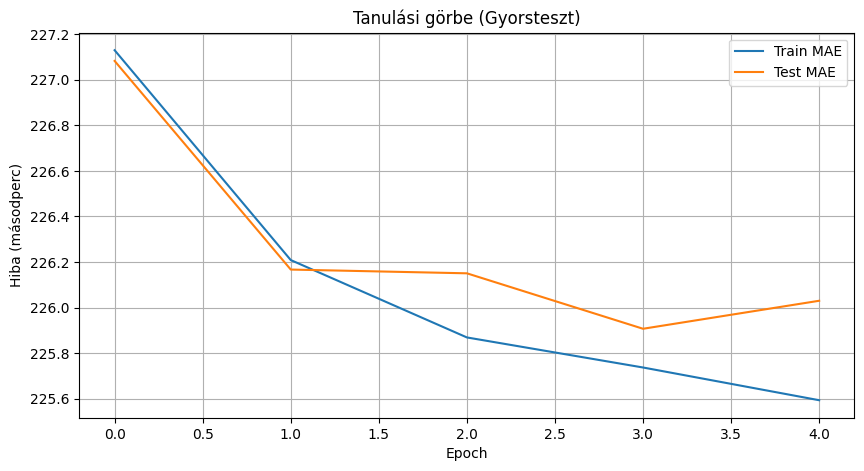

In [ ]:
from tqdm.notebook import tqdm

SAMPLE_RATE = 0.1 

print(f"Eredeti méret: {len(df_train)} sor")
df_sampled = df_train.sample(frac=SAMPLE_RATE, random_state=42).copy()
print(f"Mintavételezett méret: {len(df_sampled)} sor (Ezzel gyors lesz!)")

X_dyn_sample = torch.tensor(df_sampled[feature_cols].values, dtype=torch.float)
y_sample = torch.tensor(df_sampled['final_delay'].values, dtype=torch.float).view(-1, 1)
stop_idx_sample = torch.tensor(df_sampled['stop_idx'].values, dtype=torch.long)

train_split = int(len(df_sampled) * 0.8)
X_tr, X_te = X_dyn_sample[:train_split], X_dyn_sample[train_split:]
y_tr, y_te = y_sample[:train_split], y_sample[train_split:]
idx_tr, idx_te = stop_idx_sample[:train_split], stop_idx_sample[train_split:]

BATCH_SIZE = 2048 

train_dataset = TensorDataset(X_tr, y_tr, idx_tr)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_te, y_te, idx_te)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batch méret: {BATCH_SIZE}")
print(f"Lépések száma epochonként: {len(train_loader)}")

model = BKK_GNN_Weighted(num_node_features=2, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
criterion = torch.nn.L1Loss()

print("Tanítás indítása (Gyorsítva)...")
train_losses = []
test_maes = []

EPOCHS = 5

pbar = tqdm(range(EPOCHS), desc="Training Progress")

for epoch in pbar:
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_y, batch_idx in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        batch_idx = batch_idx.to(device)
        
        optimizer.zero_grad()
        
        out = model(x, edge_index, edge_weight, batch_X, batch_idx)
        loss = criterion(out, batch_y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    total_test_mae = 0
    with torch.no_grad():
        for batch_X_test, batch_y_test, batch_idx_test in test_loader:
            batch_X_test = batch_X_test.to(device)
            batch_y_test = batch_y_test.to(device)
            batch_idx_test = batch_idx_test.to(device)
            
            test_out = model(x, edge_index, edge_weight, batch_X_test, batch_idx_test)
            total_test_mae += criterion(test_out, batch_y_test).item()
    
    avg_test_mae = total_test_mae / len(test_loader)
    test_maes.append(avg_test_mae)
    
    pbar.set_postfix({'Train MAE': f'{avg_train_loss/60:.2f} min', 'Test MAE': f'{avg_test_mae/60:.2f} min'})

print(f"Végső Test MAE: {test_maes[-1]/60:.2f} perc")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MAE')
plt.plot(test_maes, label='Test MAE')
plt.title("Tanulási görbe (Gyorsteszt)")
plt.xlabel("Epoch")
plt.ylabel("Hiba (másodperc)")
plt.legend()
plt.grid(True)
plt.show()